In [20]:
import numpy as np
import tensorflow as tf
import csv
import cv2
import tqdm
from functools import partial
import matplotlib.pyplot as plt

In [21]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
IMG_SIZE = 128
IMG_NUM_TRAIN = 36060
IMG_NUM_VAL = 4188
IMG_NUM_TEST = 1596

images_path = "./gdrive/MyDrive/lumen/data/"

In [23]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [24]:
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        # 'height' : _int64_feature(image.shape[0]),
        # 'width' : _int64_feature(image.shape[1]),
        # 'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image)),
        'x_coord' : _float_feature(label[0]),
        'y_coord' : _float_feature(label[1])
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

In [25]:
def parse_tfr_element(element):
  #use the same structure as above; it's kinda an outline of the structure we now want to create
  data = {
      # 'height': tf.io.FixedLenFeature([], tf.int64),
      # 'width':tf.io.FixedLenFeature([], tf.int64),
      'raw_image' : tf.io.FixedLenFeature([], tf.string),
      'x_coord' : tf.io.FixedLenFeature([], tf.float32),
      'y_coord' : tf.io.FixedLenFeature([], tf.float32)
    }

    
  content = tf.io.parse_single_example(element, data)
  
  # height = content['height']
  # width = content['width']
  x = content['x_coord']
  y = content['y_coord']
  raw_image = content['raw_image']
  
  
  #get our 'feature'-- our image -- and reshape it appropriately
  feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
  feature = tf.reshape(feature, shape=[128, 128,3])
  return (feature, [x, y])

In [26]:
def get_data(annotations_path, start=0, end=60000, balance=None, test=False):
  annotations = open(annotations_path)
  images = []
  labels = []
  x, y = [], []
  if test == True:
    ground = []
  brojac = 0
  csv_reader = csv.reader(annotations)
  next(csv_reader)
  for row in csv_reader:
    if brojac % 500 == 0:
      print(brojac)
    if brojac >= start:
      if brojac >= end:
        break
      image_number = 0
      try:
        image = cv2.imread(images_path + row[0]) 
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        images.append(image)
        if test == True:
            ground.append((row[1], row[2]))
        if len(row) == 4:
          label = regions_to_labels[row[3]]
          # label = [0, 0, 0, 0, 0, 0]
          # label[regions_to_labels[row[3]]] = 1
          labels.append(label)
          # labels_summary[regions_to_labels[row[3]]] += 1
        elif len(row) == 6:
          labels.append((float(row[4]), float(row[5])))
        else:
          print("Wrong annotations format")
          print("Annotations format like:", row)
      except:
        print("Missing:", images_path + row[0])
    brojac += 1
  annotations.close()
  print(labels[:10])
  if test == True:
    return np.array(images), np.array(labels), np.array(ground)
  return np.array(images), np.array(labels)

In [27]:
def write_images_to_tfr(images, labels, filename:str="train_record_class", max_files:int=10, out_dir:str="/content/", start:int=0):

  #determine the number of shards (single TFRecord files) we need:
  splits = (len(images)//max_files) + 1 #determine how many tfr shards are needed
  if len(images) % max_files == 0:
    splits -= 1
  print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

  file_count = 0
  for i in tqdm.tqdm(range(splits)):
    current_shard_name = "{}{}_{}{}.tfrecords".format(out_dir, start+i+1, splits, filename)
    writer = tf.io.TFRecordWriter(current_shard_name)

    current_shard_count = 0
    while current_shard_count < max_files: #as long as our shard is not full
      #get the index of the file that we want to parse now
      index = i*max_files+current_shard_count
      if index == len(images): #when we have consumed the whole data, preempt generation
        break
      current_image = images[index]
      current_label = labels[index]

      #create the required Example representation
      out = parse_single_image(image=current_image, label=current_label)
      writer.write(out.SerializeToString())
      current_shard_count+=1
      file_count += 1

    writer.close()
  print(f"\nWrote {file_count} elements to TFRecord")
  return file_count

In [28]:
train_annotations_path = "./gdrive/MyDrive/lumen/regression_train_annotations.csv"
validation_annotations_path = "./gdrive/MyDrive/lumen/regression_validation_annotations.csv"
test_annotations_path = "./gdrive/MyDrive/lumen/regression_test_annotations.csv"
train_records_path = "./gdrive/MyDrive/tf_records/regression_train"
validation_records_path = "./gdrive/MyDrive/tf_records/regression_validation"

In [29]:
# for i in range(0, IMG_NUM_TRAIN//9000 + 1):
#   x, y = get_data(annotations_path=train_annotations_path, start=i * 9000, end = (i + 1) * 9000)
#   write_images_to_tfr(x, y, filename="train_record_class", max_files=9000, out_dir=train_records_path, start=i)

# for i in range(0, IMG_NUM_VAL//9000 + 1):
#   x, y = get_data(annotations_path=validation_annotations_path, start=i * 9000, end = (i + 1) * 9000)
#   write_images_to_tfr(x, y, filename="validation_record_class", max_files=9000, out_dir=validation_records_path, start=i)

In [30]:
TRAIN_FILENAMES = tf.io.gfile.glob(train_records_path + "/*.tfrecords")
print(train_records_path + "/train*.tfrec")
print("Train TFRecord Files:", len(TRAIN_FILENAMES))

VALID_FILENAMES = tf.io.gfile.glob(validation_records_path + "/*.tfrecords")
print(validation_records_path + "/train*.tfrec")
print("Train TFRecord Files:", len(VALID_FILENAMES))

AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128
IMAGE_SIZE = (128, 128)

./gdrive/MyDrive/tf_records/regression_train/train*.tfrec
Train TFRecord Files: 5
./gdrive/MyDrive/tf_records/regression_validation/train*.tfrec
Train TFRecord Files: 1


In [31]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [32]:
def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
          'raw_image' : tf.io.FixedLenFeature([], tf.string),
          'x_coord' : tf.io.FixedLenFeature([], tf.float32),
          'y_coord' : tf.io.FixedLenFeature([], tf.float32)
        }
        if labeled
        else {"raw_image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["raw_image"])
    if labeled:
        x = tf.cast(example["x"], tf.float32)
        y = tf.cast(example["y"], tf.float32)
        return image, [x, y]
    return image

In [33]:
def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        parse_tfr_element, num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

In [34]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

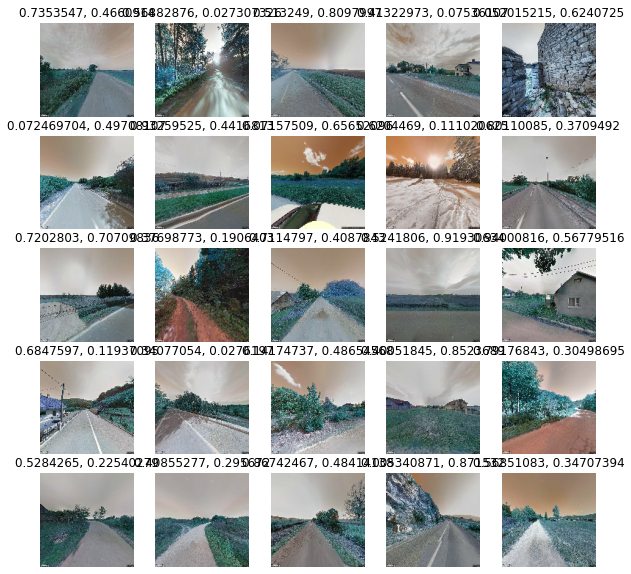

In [35]:
train_dataset = get_dataset(TRAIN_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
# test_dataset = get_dataset(TEST_FILENAMES, labeled=False)


image_batch, coords_batch = next(iter(train_dataset))
# image_batch, coords_batch = next(iter(valid_dataset))

def show_batch(image_batch, coords_batch):
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(image_batch[n] / 255.0)
      plt.title(str(coords_batch[n][0]) + ", " + str(coords_batch[n][1]))
      plt.axis("off")

show_batch(image_batch.numpy(), coords_batch.numpy())